# Figure 5: Functional clustering of G32

# import

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import interpolate
from sklearn.decomposition import SparsePCA
from scipy.stats import mannwhitneyu
from scipy import stats
from statannotations.Annotator import Annotator
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy.integrate import simps
from sklearn.cluster import AgglomerativeClustering
import scikit_posthocs as sp

# --------------------------------------------------------------------------------------------------

# Load data

In [2]:
file_path = 'ADD_YOUR_PATH_TO_DATA_HERE'

# Ctrl 1
with open(file_path+'/ctrl_dataset_c1.pkl', 'rb') as handle:
    dict_c1 = pickle.load(handle)
    
# Ctrl 2
with open(file_path+'/ctrl_dataset_c2.pkl', 'rb') as handle:
    dict_c2 = pickle.load(handle)
    
# Ctrl
with open(file_path+'/no_dataset_c.pkl', 'rb') as handle:
    dict_c_no = pickle.load(handle)
    
# DETA/NO
with open(file_path+'/no_dataset_no.pkl', 'rb') as handle:
    dict_d_no = pickle.load(handle)

# --------------------------------------------------------------------------------------------------

# Extract only type 32

In [3]:
# SbC Ctrl
idx_g32_ctrl = np.where(dict_c1['cell_type']==32)[0]
idx_g32_no = np.where(dict_c_no['cell_type']==32)[0]

print(idx_g32_ctrl.shape[0],idx_g32_no.shape[0])

251 135


In [4]:
# concatenate traces
control1 = np.hstack((dict_c1['chirp'],dict_c1['bar']))[idx_g32_ctrl]
control_d = np.hstack((dict_c_no['chirp'],dict_c_no['bar']))[idx_g32_no]
ctrl_both = np.vstack((control1,control_d))

# combines traces
ctrl_chirp_both = np.asarray(np.vstack((dict_c1['chirp'][idx_g32_ctrl],dict_c_no['chirp'][idx_g32_no])))
ctrl_bar_both = np.asarray(np.vstack((dict_c1['bar'][idx_g32_ctrl],dict_c_no['bar'][idx_g32_no])))

# dataset type labels
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

# --------------------------------------------------------------------------------------------------

# sparse PCA

In [5]:
# standardize time bins
sc = StandardScaler()
control_stand = sc.fit_transform(ctrl_both)
print(control_stand.min(),control_stand.max())

-9.741738965572118 8.895919505623889


In [6]:
random_state=42
n_components_bar=10
spca = SparsePCA(n_components=n_components_bar, alpha=2, random_state=random_state)#,n_jobs=n_jobs)
spca.fit(ctrl_bar_both)
traces_transformed = spca.transform(ctrl_bar_both)

In [7]:
random_state=42
n_components_chirp=30
spca_chirp = SparsePCA(n_components=n_components_chirp, alpha=3, random_state=random_state)#,n_jobs=n_jobs)
spca_chirp.fit(ctrl_chirp_both)
traces_transformed_chirp = spca_chirp.transform(ctrl_chirp_both)

In [8]:
zero_comp_bar = np.where(np.mean(spca.components_,axis=1)==0)
zero_comp_chirp = np.where(np.mean(spca_chirp.components_,axis=1)==0)

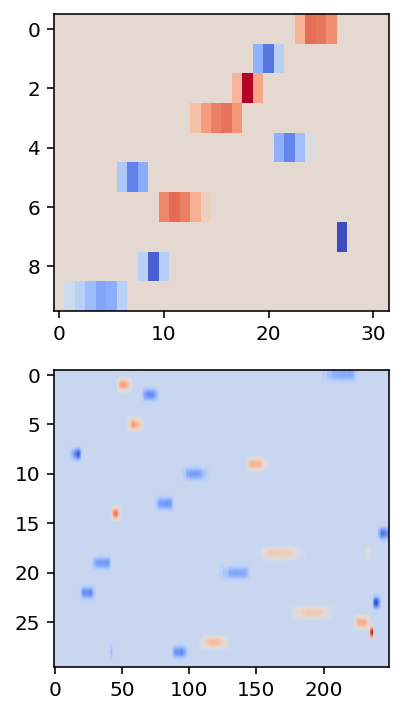

In [9]:
fig,ax=plt.subplots(2,1,figsize=(3,6))
ax[0].imshow(spca.components_,aspect='auto',cmap='coolwarm')
ax[1].imshow(spca_chirp.components_,aspect='auto',cmap='coolwarm')

In [10]:
# discard zero components
spca_com_bar = np.delete(spca.components_, zero_comp_bar, 0)
spca_com_chirp = np.delete(spca_chirp.components_, zero_comp_chirp, 0)

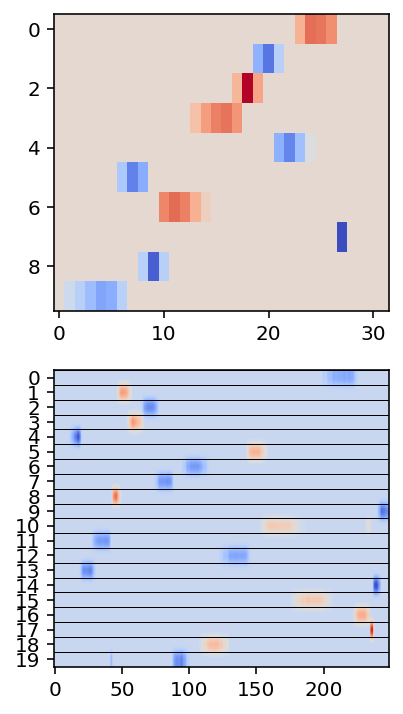

In [11]:
fig,ax=plt.subplots(2,1,figsize=(3,6))
ax[0].imshow(spca_com_bar,aspect='auto',cmap='coolwarm')
ax[1].imshow(spca_com_chirp,aspect='auto',cmap='coolwarm')
ax[1].set_yticks(np.arange(0,20,1));
for i in range(20):
    ax[1].axhline(i-.5,color='k',lw=0.5)

### sort components

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

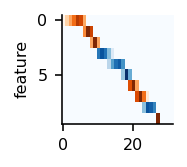

In [13]:
sort_spca_bar = [8,5,7,3,4,2,1,0,6]
sort_spca_bar = [9,5,8,6,3,2,1,4,0,7]

bar_spca_sorted = spca_com_bar[sort_spca_bar]

fig,ax=plt.subplots(1,1,figsize=(1,1))
cax = ax.imshow(bar_spca_sorted,aspect='auto',cmap=orange_blue,vmin=-.7,vmax=.7,interpolation='none')
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

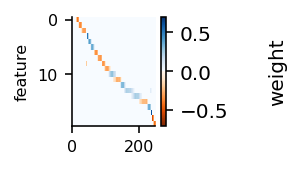

In [14]:
sort_spca_chirp = [4,13,11,8,1,3,2,7,19,6,18,12,5,10,15,0,16,17,14,9]
chirp_spca_sorted = spca_com_chirp[sort_spca_chirp]

fig,ax=plt.subplots(1,1,figsize=(1,1))
cax = ax.imshow(chirp_spca_sorted,aspect='auto',cmap=orange_blue,vmin=-0.7,vmax=0.7,interpolation='none')
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

fig.subplots_adjust(right=0.85)
cbar = fig.colorbar(cax)#, cax=cbar_ax)#, shrink=0.92)
cbar.set_label('weight', rotation=90)#,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

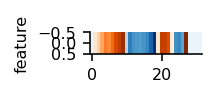

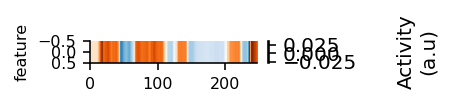

In [15]:
fig,ax=plt.subplots(1,1,figsize=(1,0.2))
ax.imshow(np.mean(bar_spca_sorted,axis=0)[:,None].T,aspect='auto',cmap=orange_blue)
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()


fig,ax=plt.subplots(1,1,figsize=(2,0.2))
cax = ax.imshow(np.mean(chirp_spca_sorted,axis=0)[:,None].T,aspect='auto',cmap=orange_blue)#,vmax=0.5,vmin=-.5)
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()
fig.subplots_adjust(right=0.85)
cbar = fig.colorbar(cax)#, cax=cbar_ax)#, shrink=0.92)
cbar.set_label('Activity\n(a.u)', rotation=90)#,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

# ---------------------------------------------------------------------------------------

# Functional Clustering

## grid search CV for clustering

In [16]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [17]:
transformed_bar = np.delete(traces_transformed, zero_comp_bar, 1)
transformed_chirp = np.delete(traces_transformed_chirp, zero_comp_chirp, 1)

In [18]:
features = np.hstack((transformed_chirp,transformed_bar))

In [19]:
features_stand = sc.fit_transform(features)

In [20]:
param_grid = {"n_components": range(1, 11), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)

GridSearchCV(cv=5, estimator=GaussianMixture(max_iter=1000, random_state=1112),
             param_grid={'covariance_type': ['diag'],
                         'n_components': range(1, 11)},
             scoring=<function gmm_bic_score at 0x7fc3c9f3ddd0>)

In [21]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
2,3,diag,6421.005079
1,2,diag,6478.985229
3,4,diag,6595.016381
4,5,diag,6727.413744
5,6,diag,6867.676516


## plot norm. BIC

In [22]:
bic = np.zeros(10)
for i in range(1,11):
    bic[i-1] = df[df['Number of components']==i]['BIC score'].min()
bic = bic/bic.min()

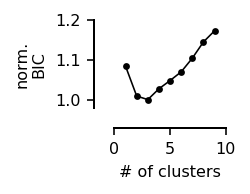

In [23]:
fig, ax = plt.subplots(1,1,figsize=(2,1.5))

ax.scatter(np.arange(1,10,1),bic[0:9],color='k',lw=2,marker='o',s=2)
ax.plot(np.arange(1,10,1),bic[0:9],color='k',lw=0.8)
ax.set_xlabel('# of clusters',fontsize=8)
ax.set_ylabel('norm.\nBIC',fontsize=8)
ax.set_xlim(0,10)
ax.set_ylim(0.98,1.2)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.despine()
fig.tight_layout()

In [29]:
cluster_labels_old = grid_search.predict(features_stand)
n_cluster_lowest_bic = len(np.unique(cluster_labels_old))

In [30]:
# reorder cluster labels
idx_label_0 = np.where(cluster_labels_old==0)[0]
idx_label_1 = np.where(cluster_labels_old==1)[0]
idx_label_2 = np.where(cluster_labels_old==2)[0]

In [31]:
cluster_labels = np.zeros(cluster_labels_old.shape[0])
cluster_labels[idx_label_0] = 0
cluster_labels[idx_label_1] = 2
cluster_labels[idx_label_2] = 1

In [32]:
n_cells_per_cluster_sbc = np.zeros(n_cluster_lowest_bic)
for i in range(n_cluster_lowest_bic):
    n_cells_per_cluster_sbc[i] = np.where(cluster_labels==i)[0].shape[0]

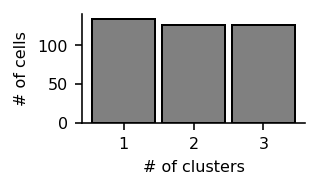

In [33]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.bar(np.arange(1,n_cluster_lowest_bic+1,1),n_cells_per_cluster_sbc,color='gray',edgecolor='k',width=.9);
#ax.set_title('SbC')
ax.set_xlabel('# of clusters',fontsize=8)
ax.set_ylabel('# of cells',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

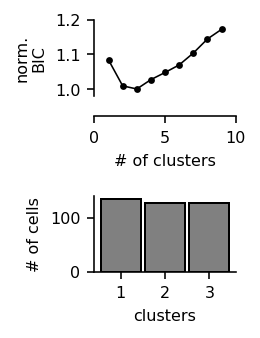

In [34]:
fig, ax = plt.subplots(2,1,figsize=(2,2.5))

ax[0].scatter(np.arange(1,10,1),bic[0:9],color='k',lw=2,marker='o',s=2)
ax[0].plot(np.arange(1,10,1),bic[0:9],color='k',lw=0.8)
ax[0].set_xlabel('# of clusters',fontsize=8)
ax[0].set_ylabel('norm.\nBIC',fontsize=8)
ax[0].set_xlim(0,10)
ax[0].set_ylim(0.98,1.2)

ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].spines['bottom'].set_position(('outward', 10))


ax[1].bar(np.arange(1,n_cluster_lowest_bic+1,1),n_cells_per_cluster_sbc,color='gray',edgecolor='k',width=.9);
ax[1].set_xlabel('clusters',fontsize=8)
ax[1].set_ylabel('# of cells',fontsize=8)
ax[1].tick_params(axis='both', which='major', labelsize=8)


sns.despine()
fig.tight_layout()

## Visualize clusters

In [36]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [37]:
chirp_label = np.hstack((cluster_labels[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels[:,None],ctrl_bar_both))

In [38]:
sorted_resp_matrix_chirp = np.zeros_like(chirp_label)
sorted_resp_matrix_bar = np.zeros_like(bar_label)
cluster_lines = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels==i)[0]
    sorted_resp_matrix_chirp[counter:counter+len(idx),:] = chirp_label[idx]
    sorted_resp_matrix_bar[counter:counter+len(idx),:] = bar_label[idx]
    cluster_lines[i]=len(idx)
    counter=counter+len(idx)

# Plot cluster means

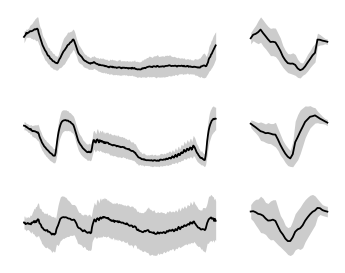

In [39]:
num_clusters = len(np.unique(cluster_labels))

fig,ax = plt.subplots(n_cluster_lowest_bic,2,figsize=(2.5,2),gridspec_kw={'width_ratios': [2.5, 1.]})

for i in range(0,n_cluster_lowest_bic):
    idx = np.where(cluster_labels==i)[0]
    
    # Ctrl 1
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black',lw=0.9)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,0].axis('off')
    #ax[i,0].set_title('Cluster ID: ' + str(i) + ' Ctrl\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,1].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black',lw=0.9)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].axis('off')
fig.tight_layout()    

## plot with scan 2

In [40]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [41]:
chirp_label = np.hstack((cluster_labels[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels[:,None],ctrl_bar_both))

In [42]:
# combines traces scan 2
no_chirp_both = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
no_bar_both = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

In [43]:
cluster_labels_ctrl = cluster_labels[:dict_c2['chirp'][idx_g32_ctrl].shape[0]]
cluster_labels_no = cluster_labels[dict_c2['chirp'][idx_g32_ctrl].shape[0]:]

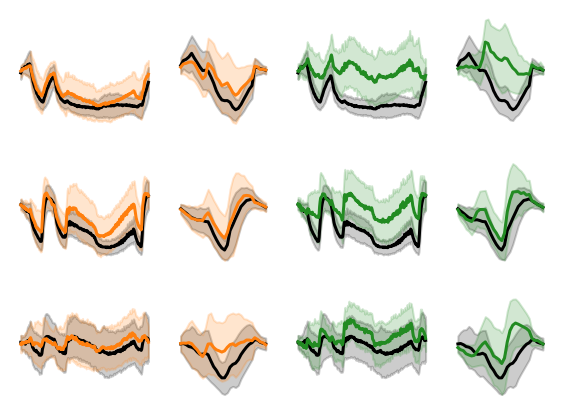

In [45]:
num_clusters = len(np.unique(cluster_labels))

color_ctrl = 'tab:orange'
color_no = 'forestgreen'
fig,ax = plt.subplots(num_clusters,4,figsize=(4,3),gridspec_kw={'width_ratios': [3, 2, 3, 2,]},sharey=True)

for i in range(0,num_clusters):
    idx = np.where(cluster_labels==i)[0]
    # Ctrl 1
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black')
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black')
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,1].axis('off')
    
    # Ctrl 2
    idx = np.where(cluster_labels_ctrl==i)[0]
    ax[i,0].plot(np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),color=color_ctrl)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0)+np.std(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0)-np.std(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),alpha=0.2,color=color_ctrl)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),color=color_ctrl)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0)+np.std(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0)-np.std(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),alpha=0.2,color=color_ctrl)
    ax[i,1].axis('off')
    
    
##########################   
    # Ctrl 1
    idx = np.where(cluster_labels==i)[0]
    ax[i,2].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black')
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,2].axis('off')
    
    ax[i,3].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black')
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,3].axis('off')
    
    # DETA/NO
    idx = np.where(cluster_labels_no==i)[0]
    ax[i,2].plot(np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),color=color_no)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0)+np.std(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0)-np.std(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),alpha=0.2,color=color_no)
    ax[i,2].axis('off')
    #ax[i,2].set_title('ID: ' + str(i))# + ' Ctrl/NO\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,3].plot(np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),color=color_no)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0)+np.std(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0)-np.std(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),alpha=0.2,color=color_no)
    ax[i,3].axis('off')
    
fig.tight_layout()    

# -----------------------------------------------------------------------------------------------------------------

# Clean cluster 3 as this apears very noisy

## Hierarchical clustering of cluster 2

In [47]:
idx_cluster_2=cluster_labels==2

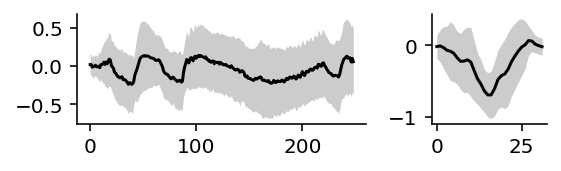

In [48]:
fig,ax=plt.subplots(1,2,figsize=(4,1.3),gridspec_kw={'width_ratios': [2.5, 1.]})
ax[0].plot(np.mean(ctrl_chirp_both[idx_cluster_2],axis=0),color='k')
ax[1].plot(np.mean(ctrl_bar_both[idx_cluster_2],axis=0),color='k')

ax[0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
sns.despine()
fig.tight_layout()

In [49]:
ctrl_both_32 = np.hstack((ctrl_chirp_both[idx_cluster_2],ctrl_bar_both[idx_cluster_2]))

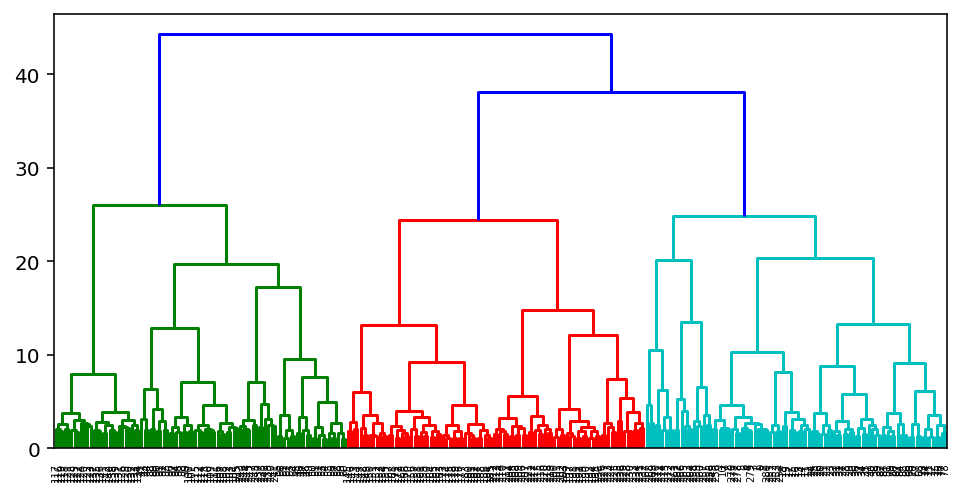

In [50]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
linkage_data = linkage(ctrl_both_32.T, method='ward', metric='euclidean')#,distance_threshold=avg_dist[:30,:30].mean())
dendrogram(linkage_data);

In [51]:
clustering_model = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
clustering_model.fit(ctrl_both_32)

AgglomerativeClustering(n_clusters=3)

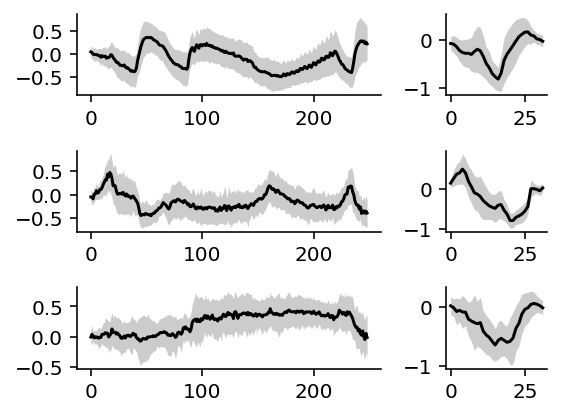

In [53]:
fig,ax = plt.subplots(3,2,figsize=(4,3),gridspec_kw={'width_ratios': [3, 1]})#,sharey=True)

for i in range(0,3):
    idx = np.where(clustering_model.labels_==i)[0]
    
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0),color='k')
    ax[i,1].plot(np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0),color='k')

    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')

sns.despine()
fig.tight_layout()

## Only pick cluster 3 and reject the rest

In [54]:
# combines traces of scan 2
ctrl_chirp_both_scan2 = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
ctrl_bar_both_scan2 = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

ctrl_both_32_scan2 = np.hstack((ctrl_chirp_both_scan2[idx_cluster_2],ctrl_bar_both_scan2[idx_cluster_2]))

In [55]:
idx = np.where(clustering_model.labels_==0)[0]
idx_ctrl_dataset_1 = np.where(label_dataset[idx_cluster_2][idx]==0)[0]
idx_ctrl_dataset_2 = np.where(label_dataset[idx_cluster_2][idx]==1)[0]

# visualize traces with cleaned cluster 3

In [57]:
idx_label_2 = np.where(clustering_model.labels_==0)[0]
idx_label_others = np.where(clustering_model.labels_!=0)[0]

# extract only cluster 2 cells that were reclustered
idx_cluster_2 = np.where(cluster_labels==2)[0]

# assign another label to the clusters that will be rejcted
cluster_labels_re = cluster_labels.copy()
cluster_labels_re[idx_cluster_2[idx_label_others]]=3

In [58]:
chirp_label = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

In [59]:
sorted_resp_matrix_chirp = np.zeros_like(chirp_label)
sorted_resp_matrix_bar = np.zeros_like(bar_label)
cluster_lines = np.zeros(n_cluster_lowest_bic+1)
counter=0
for i in range(n_cluster_lowest_bic+1):
    idx = np.where(cluster_labels_re==i)[0]
    sorted_resp_matrix_chirp[counter:counter+len(idx),:] = chirp_label[idx]
    sorted_resp_matrix_bar[counter:counter+len(idx),:] = bar_label[idx]
    cluster_lines[i]=len(idx)
    counter=counter+len(idx)

# --------------------------------------------------------------------------------------------------

# compute indices and differences

In [60]:
chirp_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

chirp_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both_scan2))
bar_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both_scan2))

In [61]:
ctrl_c1_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==0)[0]]
ctrl_c1_bar = bar_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_bar = bar_ctrl_label_scan2[np.where(label_dataset==0)[0]]

ctrl_c_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==1)[0]]
ctrl_c_bar = bar_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_bar = bar_ctrl_label_scan2[np.where(label_dataset==1)[0]]

In [62]:
idx_good_types_ctrl = np.where(ctrl_c1_chirp[:,0]!=3)[0]
idx_good_types_no = np.where(ctrl_c_chirp[:,0]!=3)[0]

In [63]:
ctrl_c1_chirp = ctrl_c1_chirp[idx_good_types_ctrl]
ctrl_c2_chirp = ctrl_c2_chirp[idx_good_types_ctrl]
ctrl_c1_bar = ctrl_c1_bar[idx_good_types_ctrl]
ctrl_c2_bar = ctrl_c2_bar[idx_good_types_ctrl]

ctrl_c_chirp = ctrl_c_chirp[idx_good_types_no]
ctrl_no_chirp = ctrl_no_chirp[idx_good_types_no]
ctrl_c_bar = ctrl_c_bar[idx_good_types_no]
ctrl_no_bar = ctrl_no_bar[idx_good_types_no]

# sort 

ctrl_c1_chirp = ctrl_c1_chirp[ctrl_c1_chirp[:,0].argsort()]
ctrl_c2_chirp = ctrl_c2_chirp[ctrl_c2_chirp[:,0].argsort()]
ctrl_c1_bar = ctrl_c1_bar[ctrl_c1_chirp[:,0].argsort()]
ctrl_c2_bar = ctrl_c2_bar[ctrl_c2_chirp[:,0].argsort()]

ctrl_c_chirp = ctrl_c_chirp[ctrl_c_chirp[:,0].argsort()]
ctrl_no_chirp = ctrl_no_chirp[ctrl_no_chirp[:,0].argsort()]
ctrl_c_bar = ctrl_c_bar[ctrl_c_chirp[:,0].argsort()]
ctrl_no_bar = ctrl_no_bar[ctrl_no_chirp[:,0].argsort()]

## suppression index

In [64]:
def suppression_index(data):
    auc_pos = simps(np.clip(data,0.01,1))
    auc_neg = simps(np.clip(data,-1,-0.01))
    total_auc = abs(auc_pos)+abs(auc_neg)
    sup_idx = abs(auc_neg)/total_auc
    
    return sup_idx

In [65]:
c1_both = np.hstack((ctrl_c1_chirp[:,1:],ctrl_c1_bar[:,1:]))
c2_both = np.hstack((ctrl_c2_chirp[:,1:],ctrl_c2_bar[:,1:]))
c_no_both = np.hstack((ctrl_c_chirp[:,1:],ctrl_c_bar[:,1:]))
d_no_both = np.hstack((ctrl_no_chirp[:,1:],ctrl_no_bar[:,1:]))

In [66]:
sup_idx_c1 = np.zeros(c1_both.shape[0])    
sup_idx_c2 = np.zeros(c1_both.shape[0])    
sup_idx_c_no = np.zeros(c_no_both.shape[0])    
sup_idx_d_no = np.zeros(c_no_both.shape[0])    

for i in range(c1_both.shape[0]):
    sup_idx_c1[i] = suppression_index(c1_both[i,:])
    sup_idx_c2[i] = suppression_index(c2_both[i,:])

for i in range(c_no_both.shape[0]):
    sup_idx_c_no[i] = suppression_index(c_no_both[i,:])
    sup_idx_d_no[i] = suppression_index(d_no_both[i,:])
    
sup_scan_1 = np.concatenate((sup_idx_c1,sup_idx_c_no))
sup_scan_2 = np.concatenate((sup_idx_c2,sup_idx_d_no))

In [67]:
cluster_labels_ctrl = cluster_labels_re[np.where(label_dataset==0)[0]][idx_good_types_ctrl]
cluster_labels_no = cluster_labels_re[np.where(label_dataset==1)[0]][idx_good_types_no]

In [68]:
sup_idx_all = np.concatenate((sup_idx_c1,sup_idx_c_no,sup_idx_c2,sup_idx_d_no))
cluster_ids_all = np.concatenate((cluster_labels_ctrl,cluster_labels_no,cluster_labels_ctrl,cluster_labels_no))
ctrl_cond_str = ['ctrl'] * cluster_labels_ctrl.shape[0]
ctrl_no_cond_str = ['ctrl'] * cluster_labels_no.shape[0]
ctrl2_cond_str = ['ctrl2'] * cluster_labels_ctrl.shape[0]
no_cond_str = ['NO']*cluster_labels_no.shape[0]
condition_all_str = np.concatenate((ctrl_cond_str,ctrl_no_cond_str,ctrl2_cond_str,no_cond_str))

df_si = pd.DataFrame({'sup_idx':sup_idx_all,'cluster':cluster_ids_all,'condition':condition_all_str})

## sup. idx difference (pairwise)

In [69]:
diff_si_ctrl = sup_idx_c2-sup_idx_c1
diff_si_no = sup_idx_d_no-sup_idx_c_no

diff_si = np.concatenate((diff_si_ctrl,diff_si_no))
cluster_ids_all_si = np.concatenate((cluster_labels_ctrl,cluster_labels_no))
condition_all_si = np.concatenate((ctrl_cond_str,no_cond_str))

df_si_diff = pd.DataFrame({'sup_idx_diff':diff_si,'cluster':cluster_ids_all_si,'condition':condition_all_si})

## mean trace difference

In [77]:
cluster_lines_ctrl = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels_ctrl==i)[0]
    cluster_lines_ctrl[i]=len(idx)
    counter=counter+len(idx)
    
cluster_lines_no = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels_no==i)[0]
    cluster_lines_no[i]=len(idx)
    counter=counter+len(idx)    

In [78]:
n_cells_cluster_ctrl = np.cumsum(cluster_lines_ctrl)
n_cells_cluster_no = np.cumsum(cluster_lines_no)

In [79]:
diff_ctrl = []
diff_no = []
for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_both_temp = c1_both[idx,:]
    c2_both_temp = c2_both[idx,:]
    diff_ctrl.append(np.mean(c2_both_temp-c1_both_temp,axis=1))
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both_temp = c_no_both[idx,:]
    no_both_temp = d_no_both[idx,:]
    diff_no.append(np.mean(no_both_temp-c_both_temp,axis=1))
        
diff_ctrl = np.concatenate(diff_ctrl)
diff_no = np.concatenate(diff_no)

diff_both = np.concatenate((diff_ctrl,diff_no))

In [80]:
cluster_label_ctrl_str = []
cluster_label_no_str = []
for i in range(0,3):
    cluster_label_ctrl_str.append([str(i+1)]*int(cluster_lines_ctrl[i]))
    cluster_label_no_str.append([str(i+1)]*int(cluster_lines_no[i]))

In [81]:
cluster_label_ctrl = ctrl_c1_chirp[:,0].copy()
cluster_label_no = ctrl_c_chirp[:,0].copy()
cluster_ids_df = np.concatenate((cluster_label_ctrl,cluster_label_no))

In [82]:
condition_str = np.concatenate((['ctrl']*int(diff_ctrl.shape[0]),['no']*int(diff_no.shape[0])))
df_diff = pd.DataFrame({'diff':diff_both,'cluster':cluster_ids_df.astype('int'),'condition':condition_str})

## MSE

In [83]:
mse_ctrl = []
mse_no = []
for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    #c1_both = np.hstack((dict_c1['chirp'][idx_g32_ctrl][idx,:],dict_c1['bar'][idx_g32_ctrl][idx,:]))
    #c2_both = np.hstack((dict_c2['chirp'][idx_g32_ctrl][idx,:],dict_c2['bar'][idx_g32_ctrl][idx,:]))
    c1_both_temp = c1_both[idx,:]
    c2_both_temp = c2_both[idx,:]
    temp = np.zeros(c1_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = mean_squared_error(c2_both_temp[j,:],c1_both_temp[j,:])
    mse_ctrl.append(temp)
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both_temp = c_no_both[idx,:]
    no_both_temp = d_no_both[idx,:]
    temp = np.zeros(c_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = mean_squared_error(no_both_temp[j,:],c_both_temp[j,:])
    mse_no.append(temp)
        
mse_ctrl = np.concatenate(mse_ctrl)
mse_no = np.concatenate(mse_no)

mse_both = np.concatenate((mse_ctrl,mse_no))

# create dataframe
df_mse = pd.DataFrame({'mse':mse_both,'cluster':cluster_ids_df,'condition':condition_str})

# --------------------------------------------------------------------------------------------------

# Plotting

In [84]:
X = np.random.randint(1,ctrl_chirp_both.shape[0], ctrl_chirp_both.shape[0])
ctrl_chirp_both_pseudo_shuffled = np.hstack((X[:,None],ctrl_chirp_both))
ctrl_bar_both_pseudo_shuffled = np.hstack((X[:,None],ctrl_bar_both))

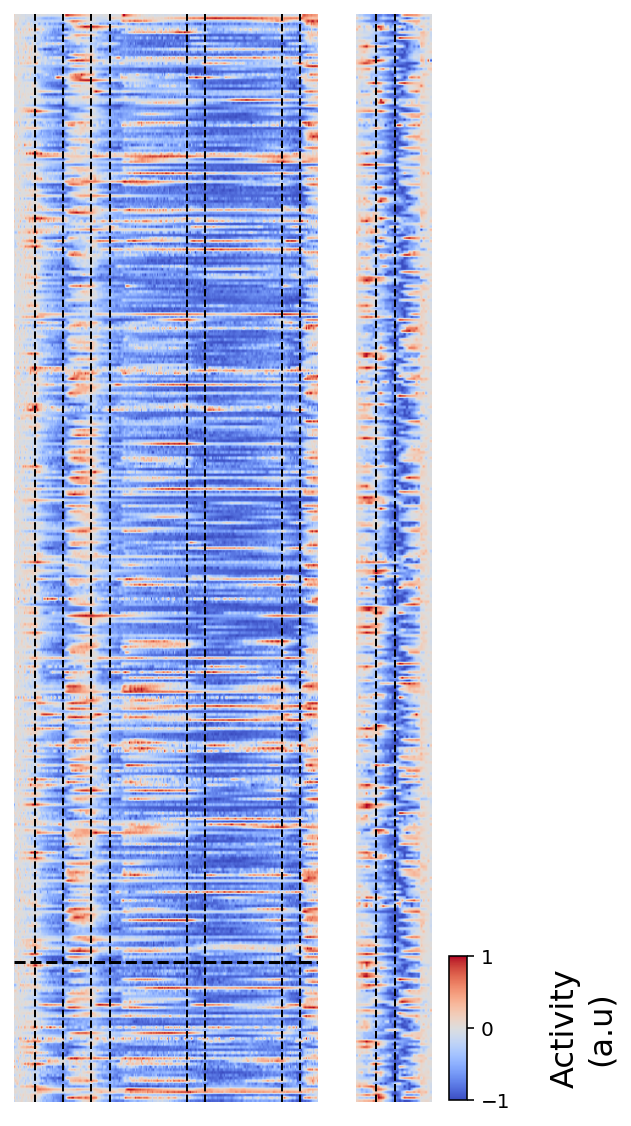

In [85]:
fig, ax = plt.subplots(1,2,figsize=(4,10),gridspec_kw={'width_ratios': [4, 1]})


ax[0].imshow(ctrl_chirp_both_pseudo_shuffled[ctrl_chirp_both_pseudo_shuffled[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
cax = ax[1].imshow(ctrl_bar_both_pseudo_shuffled[ctrl_bar_both_pseudo_shuffled[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
# lines chirp
ax[0].axvline(round(7.81*2),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*5),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*8),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*10),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*18),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*20),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*28),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*30),ls='--',color='k',lw=1)

# lines MB
ax[1].axvline(round(7.81*1.),ls='--',color='k',lw=1)
ax[1].axvline(round(7.81*2.),ls='--',color='k',lw=1)

ax[0].axhline(ctrl_chirp_both_pseudo_shuffled.shape[0]-50,ls='--',color='k')

ax[0].axis('off')
ax[1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax, cax=cbar_ax, shrink=0.92)
cbar.set_label('Activity\n(a.u)', rotation=90,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

## plot mean traces

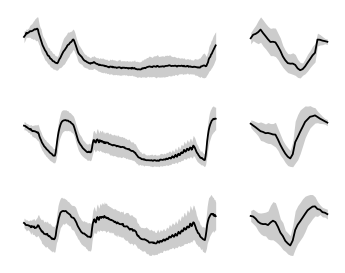

In [86]:
num_clusters = len(np.unique(cluster_labels))

fig,ax = plt.subplots(n_cluster_lowest_bic,2,figsize=(2.5,2),gridspec_kw={'width_ratios': [2.5, 1.]})

for i in range(0,n_cluster_lowest_bic):
    idx = np.where(chirp_label[:,0]==i)[0]
    
    # Ctrl 1
    ax[i,0].plot(np.mean(chirp_label[idx,1:],axis=0),color='black',lw=0.9)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(chirp_label[idx,1:],axis=0)+np.std(chirp_label[idx,1:],axis=0),np.mean(chirp_label[idx,1:],axis=0)-np.std(chirp_label[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,0].axis('off')
    #ax[i,0].set_title('Cluster ID: ' + str(i) + ' Ctrl\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,1].plot(np.mean(bar_label[idx,1:],axis=0),color='black',lw=0.9)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(bar_label[idx,1:],axis=0)+np.std(bar_label[idx,1:],axis=0),np.mean(bar_label[idx,1:],axis=0)-np.std(bar_label[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].axis('off')

fig.tight_layout()    

## plot corrected BIC and # cells plot

In [87]:
n_cells_per_cluster_sbc = np.zeros(n_cluster_lowest_bic)
for i in range(n_cluster_lowest_bic):
    n_cells_per_cluster_sbc[i] = np.where(chirp_label[:, 0]==i)[0].shape[0]

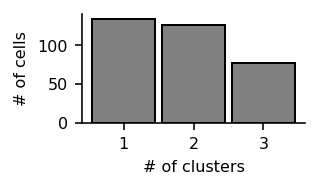

In [88]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.bar(np.arange(1,n_cluster_lowest_bic+1,1),n_cells_per_cluster_sbc,color='gray',edgecolor='k',width=.9);
#ax.set_title('SbC')
ax.set_xlabel('# of clusters',fontsize=8)
ax.set_ylabel('# of cells',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)

sns.despine()

## sort traces for heatmap by best corr

In [89]:
def argsort_traces(traces):
    """Traces (n_samples x n_time)"""
    assert traces.ndim == 2
    ccs = np.corrcoef(traces)
    ref_idx = np.argmax(np.sum(ccs, axis=0))
    sort_idxs = np.argsort(ccs[ref_idx])
    return sort_idxs

def sort_traces(traces):
    """Traces (n_samples x n_time)"""
    assert traces.ndim == 2
    sort_idxs = argsort_traces(traces)
    return traces[sort_idxs, :]

In [90]:
cluster_1 = np.hstack((chirp_label[np.where(chirp_label[:,0]==0)[0],1:],bar_label[np.where(chirp_label[:,0]==0)[0],1:]))
cluster_2 = np.hstack((chirp_label[np.where(chirp_label[:,0]==1)[0],1:],bar_label[np.where(chirp_label[:,0]==1)[0],1:]))
cluster_3 = np.hstack((chirp_label[np.where(chirp_label[:,0]==2)[0],1:],bar_label[np.where(chirp_label[:,0]==2)[0],1:]))

In [91]:
cluster_1_sorted = sort_traces(cluster_1)
cluster_2_sorted = sort_traces(cluster_2)
cluster_3_sorted = sort_traces(cluster_3)

chirp_sorted = np.vstack((cluster_1_sorted[:,:249],cluster_2_sorted[:,:249],cluster_3_sorted[:,:249],chirp_label[np.where(chirp_label[:,0]==3)[0],1:]))
bar_sorted = np.vstack((cluster_1_sorted[:,249:],cluster_2_sorted[:,249:],cluster_3_sorted[:,249:],bar_label[np.where(chirp_label[:,0]==3)[0],1:]))

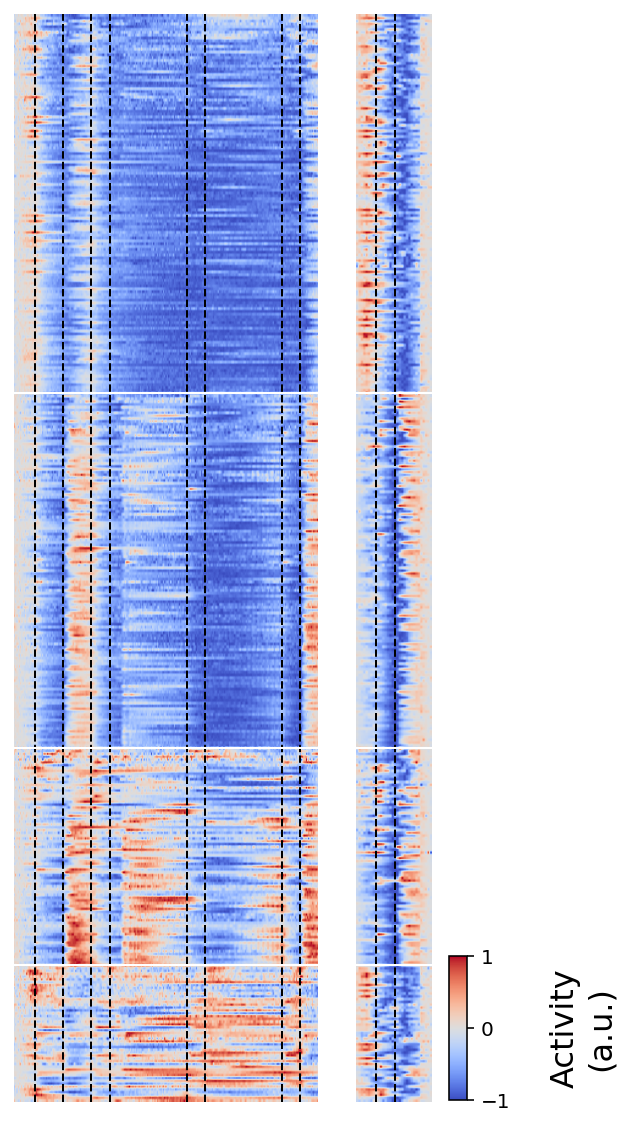

In [92]:
fig, ax = plt.subplots(1,2,figsize=(4,10),gridspec_kw={'width_ratios': [4, 1]})

ax[0].imshow(chirp_sorted,aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
cax = ax[1].imshow(bar_sorted,aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)

# lines chirp
ax[0].axvline(round(7.81*2),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*5),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*8),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*10),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*18),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*20),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*28),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*30),ls='--',color='k',lw=1)

# lines MB
ax[1].axvline(round(7.81*1.),ls='--',color='k',lw=1)
ax[1].axvline(round(7.81*2.),ls='--',color='k',lw=1)

# add cluster lines to separate them
for i in range(n_cluster_lowest_bic):#-1):
    ax[0].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')
    ax[1].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')

ax[0].axis('off')
ax[1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax, cax=cbar_ax, shrink=0.92)
cbar.set_label('Activity\n(a.u.)', rotation=90,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

# add metric

### correlation

In [93]:
corr_ctrl = []
corr_no = []
for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_both_temp = c1_both[idx,:]
    c2_both_temp = c2_both[idx,:]
    temp = np.zeros(c1_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = np.corrcoef(c2_both_temp[j,:],c1_both_temp[j,:])[0,1]
    corr_ctrl.append(temp)
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both_temp = c_no_both[idx,:]
    no_both_temp = d_no_both[idx,:]
    temp = np.zeros(c_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = np.corrcoef(no_both_temp[j,:],c_both_temp[j,:])[0,1]
    corr_no.append(temp)
        
corr_ctrl = np.concatenate(corr_ctrl)
corr_no = np.concatenate(corr_no)

corr_both = np.concatenate((corr_ctrl,corr_no))

In [94]:
df_corr = pd.DataFrame({'r':corr_both,'cluster':cluster_ids_df,'condition':condition_str})

In [95]:
idx = np.where(cluster_label_no==1)[0]
ctrl_no_chirp[idx,1:].shape

(44, 249)

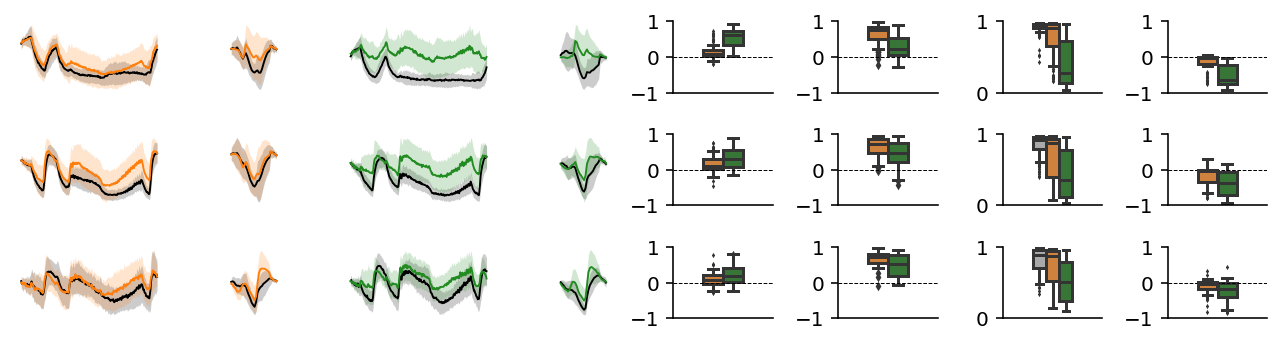

In [96]:
color_ctrl = 'k'
color_ctrl2 = 'tab:orange'
color_no = 'forestgreen'


num_clusters = len(np.unique(cluster_labels))
lw=0.95
fig,ax = plt.subplots(num_clusters,8,figsize=(9,2.5),gridspec_kw={'width_ratios': [3, 1, 3, 1, 2, 2, 2, 2]})#,sharey=True)

for i in range(0,num_clusters):
    
##########################   
    # Ctrl 1
    idx = np.where(cluster_label_ctrl==i)[0]
    ax[i,0].plot(np.mean(ctrl_c1_chirp[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_c1_chirp[idx,1:],axis=0)+np.std(ctrl_c1_chirp[idx,1:],axis=0),np.mean(ctrl_c1_chirp[idx,1:],axis=0)-np.std(ctrl_c1_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_c1_bar[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_c1_bar[idx,1:],axis=0)+np.std(ctrl_c1_bar[idx,1:],axis=0),np.mean(ctrl_c1_bar[idx,1:],axis=0)-np.std(ctrl_c1_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,1].axis('off')
    
    # Ctrl 2
    #idx = np.where(cluster_labels_ctrl==i)[0]
    ax[i,0].plot(np.mean(ctrl_c2_chirp[idx,1:],axis=0),color=color_ctrl2,lw=lw)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_c2_chirp[idx,1:],axis=0)+np.std(ctrl_c2_chirp[idx,1:],axis=0),np.mean(ctrl_c2_chirp[idx,1:],axis=0)-np.std(ctrl_c2_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl2)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_c2_bar[idx,1:],axis=0),color=color_ctrl2,lw=lw)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_c2_bar[idx,1:],axis=0)+np.std(ctrl_c2_bar[idx,1:],axis=0),np.mean(ctrl_c2_bar[idx,1:],axis=0)-np.std(ctrl_c2_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl2)
    ax[i,1].axis('off')
    
##########################   
    # Ctrl
    idx = np.where(cluster_label_no==i)[0]
    ax[i,2].plot(np.mean(ctrl_c_chirp[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_c_chirp[idx,1:],axis=0)+np.std(ctrl_c_chirp[idx,1:],axis=0),np.mean(ctrl_c_chirp[idx,1:],axis=0)-np.std(ctrl_c_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,2].axis('off')
    
    ax[i,3].plot(np.mean(ctrl_c_bar[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_c_bar[idx,1:],axis=0)+np.std(ctrl_c_bar[idx,1:],axis=0),np.mean(ctrl_c_bar[idx,1:],axis=0)-np.std(ctrl_c_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,3].axis('off')
    
    # DETA/NO
    #idx_no = np.where(cluster_labels_no==i)[0]
    ax[i,2].plot(np.mean(ctrl_no_chirp[idx,1:],axis=0),color=color_no,lw=lw)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_no_chirp[idx,1:],axis=0)+np.std(ctrl_no_chirp[idx,1:],axis=0),np.mean(ctrl_no_chirp[idx,1:],axis=0)-np.std(ctrl_no_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_no)
    ax[i,2].axis('off')
    #ax[i,2].set_title('ID: ' + str(i))# + ' Ctrl/NO\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,3].plot(np.mean(ctrl_no_bar[idx,1:],axis=0),color=color_no,lw=lw)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_no_bar[idx,1:],axis=0)+np.std(ctrl_no_bar[idx,1:],axis=0),np.mean(ctrl_no_bar[idx,1:],axis=0)-np.std(ctrl_no_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_no)
    ax[i,3].axis('off')
    
##########################   
    # Difference
    s1 = sns.boxplot(data=df_diff[df_diff['cluster']==i],
                y='diff',
                x='cluster',
                hue='condition',
                saturation=0.6,
                fliersize=0.5,
                whis=1.,
                dodge=True,
                width=0.4,
                orient='v',
                ax=ax[i,4],
                palette=([color_ctrl2,color_no]),
                boxprops=dict(alpha=1))
    ax[i,4].legend([],[],frameon=False)
    ax[i,4].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,4].set_ylim(-1,1)
    s1.set(ylabel=None)
        
        
### correlation coefficient        
    s2 = sns.boxplot(data=df_corr[df_corr['cluster']==i],
                y='r',
                x='cluster',
                hue='condition',
                saturation=0.6,
                fliersize=2,
                whis=1.,
                dodge=True,
                width=0.4,
                orient='v',
                ax=ax[i,5],
                palette=([color_ctrl2,color_no]),
                boxprops=dict(alpha=1))
    ax[i,5].legend([],[],frameon=False)
    ax[i,5].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,5].set_ylim(-1,1)
    s2.set(ylabel=None)        
                
        
### suppression index
    s3 = sns.boxplot(data=df_si[df_si['cluster']==i],
                    y='sup_idx',
                    x='cluster',
                    hue='condition',
                    saturation=0.6,
                    fliersize=0.5,
                    whis=1.,
                    dodge=True,
                    width=0.4,
                    orient='v',
                    ax=ax[i,6],
                    palette=(['darkgray',color_ctrl2,color_no]),
                    boxprops=dict(alpha=1))
    ax[i,6].legend([],[],frameon=False)
    ax[i,6].set_ylim(0,1)
    s3.set(ylabel=None)

### SI difference    
    s4 = sns.boxplot(data=df_si_diff[df_si_diff['cluster']==i],
                    y='sup_idx_diff',
                    x='cluster',
                    hue='condition',
                    saturation=0.6,
                    fliersize=0.5,
                    whis=1.,
                    dodge=True,
                    width=0.4,
                    orient='v',
                    ax=ax[i,7],
                    palette=([color_ctrl2,color_no]),
                    boxprops=dict(alpha=1))
    ax[i,7].legend([],[],frameon=False)
    ax[i,7].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,7].set_ylim(-1,1)
    s4.set(ylabel=None)
    
    if i == 0 or i == 1 or i == 2:
        ax[i,4].get_xaxis().set_visible(False)
        ax[i,5].get_xaxis().set_visible(False)
        ax[i,6].get_xaxis().set_visible(False)
        ax[i,7].get_xaxis().set_visible(False)
       
    
fig.tight_layout()    
sns.despine()

# --------------------------------------------------------------------------------------------------

# Statistics on box plots for each cluster and metric

### trace difference

In [97]:
diff_p_values_mannu=np.zeros(3)
diff_p_values_ttest=np.zeros(3)
diff_p_values_tests=np.zeros((2,3))

for i in range(3):              
    ctrl=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='ctrl')]['diff'].values
    no=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='no')]['diff'].values
                        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    diff_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    diff_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        diff_p_values_tests[0,i] = 0
        diff_p_values_tests[1,i] = diff_p_values_ttest[i]

    else:
        diff_p_values_tests[0,i] = 1
        diff_p_values_tests[1,i] = diff_p_values_mannu[i]    

In [98]:
print('Trace difference')
print('bonferroni corrected alpha: '+str(0.05/3))
print(('-------------------------'))
for i in range(3):
    print('Cluster '+str(i+1))
    if diff_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(diff_p_values_tests[1,i]))
    if diff_p_values_tests[1,i]<0.05/3:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Trace difference
bonferroni corrected alpha: 0.016666666666666666
-------------------------
Cluster 1
not norm. dist.
p: 6.700356034227891e-13
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 0.0006970702416081782
sign. diff
-------------------------
Cluster 3
not norm. dist.
p: 0.05415829298589968
n.s.
-------------------------


### trace correlation

In [99]:
corr_p_values_mannu=np.zeros(3)
corr_p_values_ttest=np.zeros(3)
corr_p_values_tests=np.zeros((2,3))

for i in range(3):
                        
    ctrl=df_corr[(df_corr['cluster']==i) & (df_corr['condition']=='ctrl')]['r'].values
    no=df_corr[(df_corr['cluster']==i) & (df_corr['condition']=='no')]['r'].values
                        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    corr_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    corr_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        corr_p_values_tests[0,i] = 0
        corr_p_values_tests[1,i] = corr_p_values_ttest[i]

    else:
        corr_p_values_tests[0,i] = 1
        corr_p_values_tests[1,i] = corr_p_values_mannu[i]    

In [100]:
print('Correlation coefficient')
print('bonferroni corrected alpha: '+str(0.05/3))
print(('-------------------------'))
for i in range(3):
    print('Cluster '+str(i+1))
    if corr_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(corr_p_values_tests[1,i]))
    if corr_p_values_tests[1,i]<0.05/3:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Correlation coefficient
bonferroni corrected alpha: 0.016666666666666666
-------------------------
Cluster 1
not norm. dist.
p: 8.616083941132707e-11
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 0.0007481722282810124
sign. diff
-------------------------
Cluster 3
not norm. dist.
p: 0.008173783106045891
sign. diff
-------------------------


### suppression index

In [101]:
si_p_values_kruskal=np.zeros(3)

for i in range(3):
    ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
    ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
    no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
                        
    #p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    #p_value_shapiro_no = stats.shapiro(no)[1]
    
    si_p_values_kruskal[i] = stats.kruskal(ctrl, ctrl2, no)[1]

### posthoc Dunn test

In [104]:
i=0
ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
data = [ctrl,ctrl2,no]
dunn_results_cluster_1 = sp.posthoc_dunn(data, p_adjust = 'bonferroni')

i=1
ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
data = [ctrl,ctrl2,no]
dunn_results_cluster_2 = sp.posthoc_dunn(data, p_adjust = 'bonferroni')

i=2
ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
data = [ctrl,ctrl2,no]
dunn_results_cluster_3 = sp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [105]:
print('Suppression Index')
print("Dunn's test")
print('bonferroni corrected alpha: '+str(0.05/3))
print('--------------------------')
print('Cluster 1')
print('Ctrl 1 vs. Ctrl 2; p-value: '+str(dunn_results_cluster_1.iloc[0,1])+'; n.s')
print('Ctrl 1 vs. NO; p-value: '+str(dunn_results_cluster_1.iloc[0,2])+'; sign. diff.')
print('Ctrl 2 vs. NO; p-value: '+str(dunn_results_cluster_1.iloc[1,2])+'; sign. diff.')

print('--------------------------')
print('Cluster 2')
print('Ctrl 1 vs. Ctrl 2; p-value: '+str(dunn_results_cluster_2.iloc[0,1])+'; sign. diff.')
print('Ctrl 1 vs. NO; p-value: '+str(dunn_results_cluster_2.iloc[0,2])+'; sign. diff.')
print('Ctrl 2 vs. NO; p-value: '+str(dunn_results_cluster_2.iloc[1,2])+'; n.s')

print('--------------------------')
print('Cluster 3')
print('Ctrl 1 vs. Ctrl 2; p-value: '+str(dunn_results_cluster_3.iloc[0,1])+'; n.s')
print('Ctrl 1 vs. NO; p-value: '+str(dunn_results_cluster_3.iloc[0,2])+'; sign. diff.')
print('Ctrl 2 vs. NO; p-value: '+str(dunn_results_cluster_3.iloc[1,2])+'; n.s')

Suppression Index
Dunn's test
bonferroni corrected alpha: 0.016666666666666666
--------------------------
Cluster 1
Ctrl 1 vs. Ctrl 2; p-value: 0.000130809122415375; n.s
Ctrl 1 vs. NO; p-value: 5.006754166197789e-20; sign. diff.
Ctrl 2 vs. NO; p-value: 2.8627737655096217e-08; sign. diff.
--------------------------
Cluster 2
Ctrl 1 vs. Ctrl 2; p-value: 0.000563406084467424; sign. diff.
Ctrl 1 vs. NO; p-value: 9.487746884599674e-13; sign. diff.
Ctrl 2 vs. NO; p-value: 0.00019589746709886376; n.s
--------------------------
Cluster 3
Ctrl 1 vs. Ctrl 2; p-value: 0.626471549166314; n.s
Ctrl 1 vs. NO; p-value: 1.9647859057716744e-06; sign. diff.
Ctrl 2 vs. NO; p-value: 0.003022330179436956; n.s


### difference suppression index

In [106]:
si_diff_p_values_mannu=np.zeros(3)
si_diff_p_values_ttest=np.zeros(3)
si_diff_p_values_tests=np.zeros((2,3))

for i in range(3):
    ctrl=df_si_diff[(df_si_diff['cluster']==i) & (df_si_diff['condition']=='ctrl')]['sup_idx_diff'].values
    no=df_si_diff[(df_si_diff['cluster']==i) & (df_si_diff['condition']=='NO')]['sup_idx_diff'].values
         
        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    si_diff_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    si_diff_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        si_diff_p_values_tests[0,i] = 0
        si_diff_p_values_tests[1,i] = si_diff_p_values_ttest[i]

    else:
        si_diff_p_values_tests[0,i] = 1
        si_diff_p_values_tests[1,i] = si_diff_p_values_mannu[i]    

In [107]:
print('Difference Suppression Index')
print('bonferroni corrected alpha: '+str(0.05/3))
print(('-------------------------'))
for i in range(3):
    print('Cluster '+str(i+1))
    if si_diff_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(si_diff_p_values_tests[1,i]))
    if si_diff_p_values_tests[1,i]<0.05/3:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Difference Suppression Index
bonferroni corrected alpha: 0.016666666666666666
-------------------------
Cluster 1
not norm. dist.
p: 4.4758753338779264e-11
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 0.00010046529637388416
sign. diff
-------------------------
Cluster 3
not norm. dist.
p: 0.036781127366124544
n.s.
-------------------------
